In [ ]:
# Articles
# https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [300]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import datetime as dt
from pandas.plotting import autocorrelation_plot

In [301]:
data = pd.read_csv("../data/state-daily-stats.csv", parse_dates=['date'])
data.drop(columns={"Unnamed: 0"}, inplace=True)

In [302]:
for index, row in data.iterrows():
    date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
    date2 = dt.datetime.strftime(date, "%m-%d-%Y")
    data.at[index, "date"] = date2

In [303]:
data["date"] = pd.to_datetime(data["date"])
daily_new_cases = pd.DataFrame(data[["date","daily_new_cases"]])
# daily_new_cases.set_index("date", inplace=True)

In [304]:
daily_new_cases = daily_new_cases[daily_new_cases["date"] >= dt.datetime(2020,3,1)]
for index, row in daily_new_cases.iterrows():
    date = row["date"]
    new_date = dt.datetime.strftime(date, "%m-%d-%Y")
    daily_new_cases.at[index, "date"] = new_date

In [305]:
daily_new_cases.set_index("date", inplace=True)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

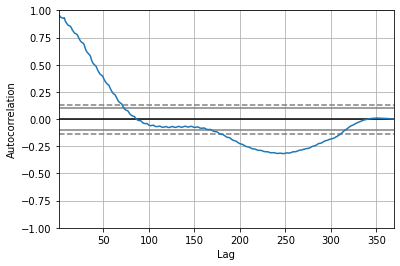

In [306]:
autocorrelation_plot(daily_new_cases)

In [307]:
log_daily_new_cases = pd.DataFrame(np.log(daily_new_cases.daily_new_cases))

<AxesSubplot:xlabel='date'>

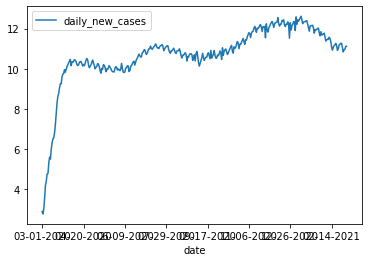

In [308]:
log_daily_new_cases.plot()

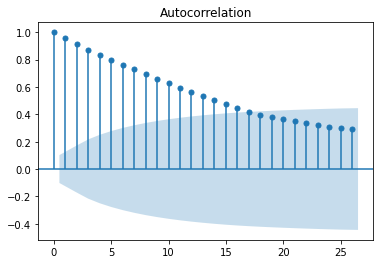

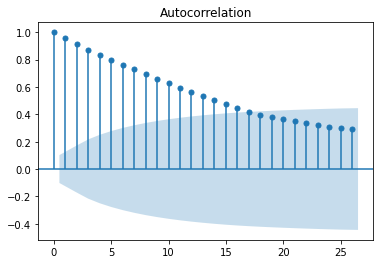

In [309]:
plot_acf(log_daily_new_cases)

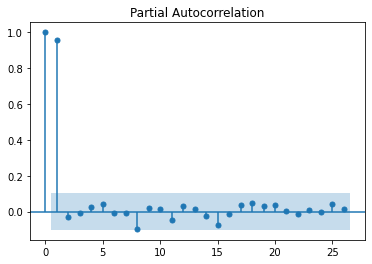

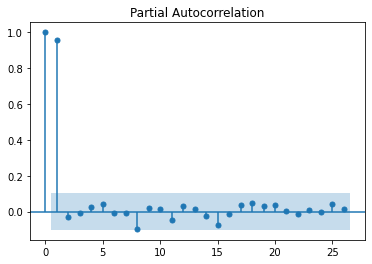

In [310]:
plot_pacf(log_daily_new_cases)

In [311]:
result = adfuller(log_daily_new_cases.daily_new_cases, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.3196529392354193
p-value: 0.01402251976095639


In [312]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

model = ARIMA(log_daily_new_cases.daily_new_cases, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.daily_new_cases   No. Observations:                  368
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 123.091
Method:                       css-mle   S.D. of innovations              0.173
Date:                Fri, 05 Mar 2021   AIC                           -236.182
Time:                        15:08:15   BIC                           -216.641
Sample:                    03-02-2020   HQIC                          -228.418
                         - 03-04-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0688      0.077      0.894      0.371      -0.082       0.220
ar.L1.D.daily_new_cases     0.9927      0.008    117.427      0.000       0.976       1.009


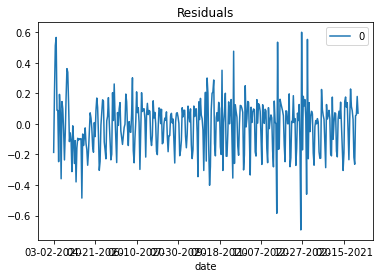

In [313]:
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals")
# residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

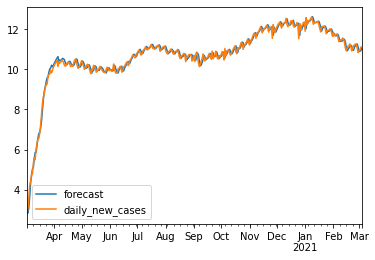

In [314]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [316]:
model_fit.predict(10) 

2020-03-11    0.261901
2020-03-12    0.356882
2020-03-13    0.218398
2020-03-14    0.238561
2020-03-15    0.276707
                ...   
2021-02-28    0.056394
2021-03-01    0.052948
2021-03-02   -0.039041
2021-03-03   -0.035739
2021-03-04   -0.059382
Freq: D, Length: 359, dtype: float64

In [317]:
training = log_daily_new_cases[:276]
testing = log_daily_new_cases[276:]

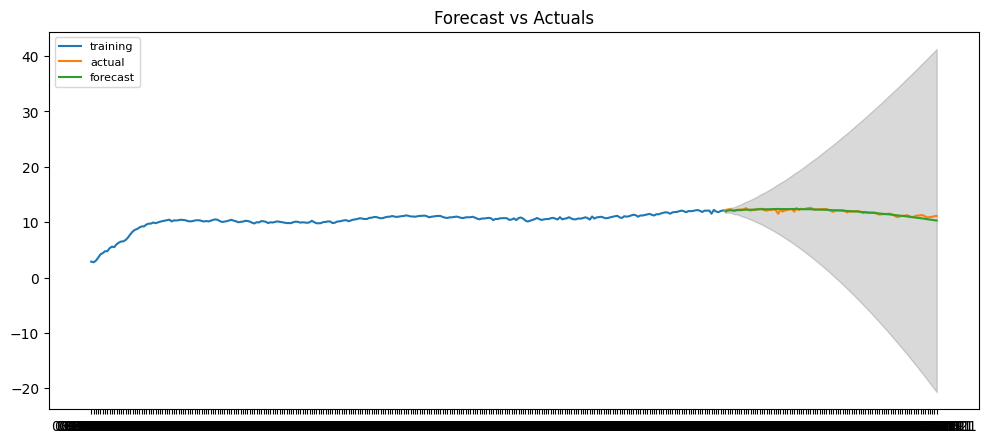

In [319]:
model = ARIMA(training, order=(5, 2, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(93, alpha=0.05)  

# Forecast
# fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=testing.index)
lower_series = pd.Series(conf[:, 0], index=testing.index)
upper_series = pd.Series(conf[:, 1], index=testing.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(testing, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [320]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D2.daily_new_cases   No. Observations:                  274
Model:                 ARIMA(5, 2, 2)   Log Likelihood                 146.914
Method:                       css-mle   S.D. of innovations              0.140
Date:                Fri, 05 Mar 2021   AIC                           -275.829
Time:                        15:10:03   BIC                           -243.311
Sample:                    03-03-2020   HQIC                          -262.777
                         - 12-01-2020                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0010      0.002     -0.538      0.591      -0.004       0.003
ar.L1.D2.daily_new_cases    -0.0122      0.060     -0.205      0.838      -0.129       0.105
ar.L2.D2.daily_new_cases    -0.4972      0.049    -10.080      0.000      -0.594      -0.401
ar.L3.D2.daily_new_cases    -0.4459      0.049     -9.064      0.000      -0.542      -0.349
ar.L4.D2.daily_new_cases    -0.3896      0.048     -8.201      0.000      -0.483      -0.296
ar.L5.D2.daily_new_cases    -0.5128      0.058     -8.858      0.000      -0.626      -0.399
ma.L1.D2.daily_new_cases    -1.2095      0.038    -31.763      0.000      -1.284      -1.135
ma.L2.D2.daily_new_cases     0.8111      0.053     15.422      0.000       0.708       0.914
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6285           -0.7897j            1.0093           -0.1430
AR.2            0.6285           +0.7897j            1.0093            0.1430
AR.3           -1.3108           -0.0000j            1.3108           -0.5000
AR.4           -0.3530           -1.1558j            1.2085           -0.2972
AR.5           -0.3530           +1.1558j            1.2085            0.2972
MA.1            0.7455           -0.8228j            1.1103           -0.1328
MA.2            0.7455           +0.8228j            1.1103            0.1328
-----------------------------------------------------------------------------
"""

In [321]:
import pmdarima as pm

In [322]:
model = pm.auto_arima(daily_new_cases.daily_new_cases, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8238.253, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8335.514, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8262.979, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8236.479, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8333.546, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8238.238, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8235.719, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8241.400, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8241.622, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8240.804, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8239.966, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8233.920, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8236.043, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : 

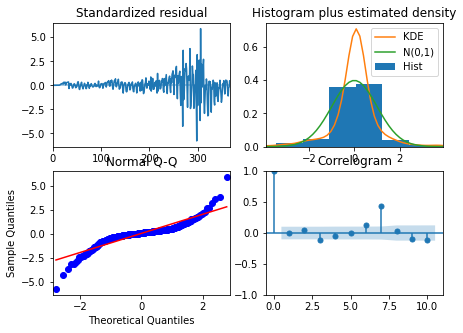

In [323]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [324]:
n_periods = 30
predictions = model.predict(n_periods=n_periods)
predictions

array([63604.5430056 , 64680.09695696, 63702.04879339, 64591.43068731,
       63782.6769033 , 64518.11202697, 63849.34876202, 64457.48439513,
       63904.48011449, 64407.35104946, 63950.06855438, 64365.8954908 ,
       63987.7659037 , 64331.6156453 , 64018.93806377, 64303.26943927,
       64044.71450644, 64279.82979463, 64066.02919861, 64260.44741449,
       64083.65444305, 64244.42001026, 64098.22886143, 64231.16685534,
       64110.28053379, 64220.20774353, 64120.24613261, 64211.14558946,
       64128.48674493, 64203.65204091])

In [325]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(daily_new_cases.daily_new_cases, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8471.492, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8216.080, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=8365.431, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8471.132, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8280.137, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8167.924, Time=1.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=8156.343, Time=1.76 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=8150.127, Time=2.03 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(2,0,0)(2,1,2)[12] intercept   : AIC=8099.809, Time=3.17 sec
 ARIMA(2,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=4.93 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  369
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -4031.011
Date:                                 Fri, 05 Mar 2021   AIC                           8084.022
Time:                                         15:13:32   BIC                           8126.677
Sample:                                              0   HQIC                          8100.988
                                                 - 369                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7418      0.094      7.888      0.000       0.557       0.926
ar.L2         -0.6485      0.111     -5.834      0.000      -0.866      -0.431
ar.L3          0.8890      0.081     11.027      0.000       0.731       1.047
ma.L1         -0.3241      0.115     -2.816      0.005      -0.550      -0.098
ma.L2          0.8435      0.085      9.908      0.000       0.677       1.010
ma.L3         -0.4543      0.092     -4.955      0.000      -0.634      -0.275
ar.S.L12      -0.6742      0.399     -1.689      0.091      -1.456       0.108
ar.S.L24      -0.1653      0.108     -1.531      0.126      -0.377       0.046
ma.S.L12      -0.1950      0.381     -0.511      0.609      -0.943       0.553
ma.S.L24      -0.5717      0.399     -1.434      0.152      -1.353       0.210
sigma2      5.991e+08   2.98e-09   2.01e+17      0.000    5.99e+08    5.99e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               893.37
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):              54.35   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.74e+32. Standard errors may be unstable.
"""

In [326]:
predictions_seasonal = smodel.predict(n_periods=n_periods)

<AxesSubplot:>

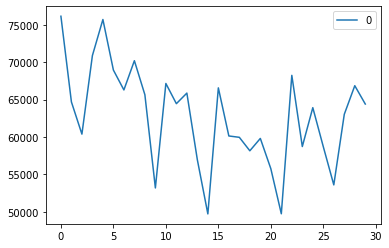

In [327]:
pd.DataFrame(predictions_seasonal).plot()

In [328]:
predictions_seasonal

array([76149.82778742, 64686.10787584, 60378.00515863, 70889.19525248,
       75712.60497569, 68949.68703723, 66290.33456403, 70202.18983624,
       65649.04689183, 53176.39833932, 67153.83639453, 64453.106464  ,
       65866.6587322 , 56940.44988324, 49702.05277634, 66567.07657022,
       60131.22460315, 59951.19094568, 58148.59736244, 59802.50053077,
       55756.32109073, 49720.28031932, 68241.61431909, 58717.5315273 ,
       63918.49531155, 58693.21100719, 53585.63107962, 63031.79109738,
       66857.39267911, 64402.66670225])

In [331]:
daily_new_cases

,daily_new_cases
date,
03-01-2020,18
03-02-2020,16
03-03-2020,21
03-04-2020,36
03-05-2020,67
...,...
02-28-2021,50925
03-01-2021,56672
03-02-2021,57789


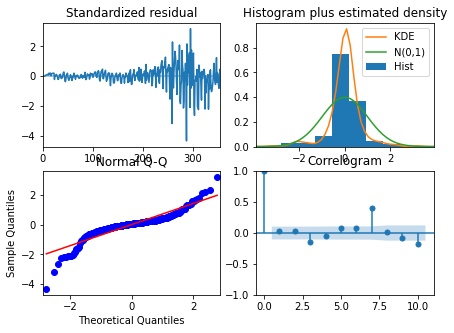

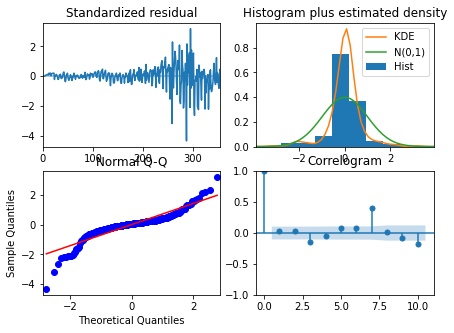

In [299]:
smodel.plot_diagnostics(figsize=(7,5))